In [ ]:
# load image from aws s3 bucket
import boto3
import tensorflow as tf
from PIL import Image
import numpy as np
s3 = boto3.resource('s3')
dataset = s3.Bucket('dalle2images')
image_paths = []

bucket_name = 'dalle2images'
for obj in dataset.objects.all():
    if obj.key.endswith('.png') and obj.key.startswith('real'):
        image_paths.append(obj.key)

    elif obj.key.endswith('.png') and obj.key.startswith('fake'):
        image_paths.append(obj.key)


print("Number of images: %d" % len(image_paths))

Number of images: 42878


In [ ]:
bucket_name = 'dalle2images'
image = []
labels = []
for i in range(1,len(image_paths), 8):
    # read image from s3 bucket
    img = s3.Object(bucket_name, image_paths[i])
    img = Image.open(img.get()['Body']).resize([128,128])
    # convert image to numpy array
    img = np.array(img).astype(np.float32)
    # img = tf.convert_to_tensor(img, dtype=tf.float32)
    # add image to list
    image.append(img/255)
    if i < 21439:
      labels.append(0)
    else:
      labels.append(1)

print("Number of images: %d" % len(image))

Number of images: 5360


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#make labels into numpy array
alllabels = np.array(labels)

In [ ]:
# reshape image
allimage = np.array(image).reshape(-1, 128, 128, 3)

In [ ]:
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(allimage, alllabels, test_size=0.2, random_state=42)

# MobileV2 model

In [ ]:
from huggingface_hub import from_pretrained_keras

reloaded_model = from_pretrained_keras('Emmawang/mobilenet_v2_fake_image_detection')

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
reloaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
history1 = reloaded_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
134/134 [==============================] - 17s 29ms/step - loss: 0.5634 - accuracy: 0.7460 - auc: 0.8178 - precision: 0.7434 - recall: 0.7514 - true_positives: 1611.0000 - true_negatives: 1588.0000 - false_positives: 556.0000 - false_negatives: 533.0000 - val_loss: 0.5061 - val_accuracy: 0.7845 - val_auc: 0.8735 - val_precision: 0.7905 - val_recall: 0.7743 - val_true_positives: 415.0000 - val_true_negatives: 426.0000 - val_false_positives: 110.0000 - val_false_negatives: 121.0000
Epoch 2/10
134/134 [==============================] - 2s 18ms/step - loss: 0.5594 - accuracy: 0.7523 - auc: 0.8213 - precision: 0.7464 - recall: 0.7645 - true_positives: 1639.0000 - true_negatives: 1587.0000 - false_positives: 557.0000 - false_negatives: 505.0000 - val_loss: 0.4946 - val_accuracy: 0.7948 - val_auc: 0.8736 - val_precision: 0.7599 - val_recall: 0.8619 - val_true_positives: 462.0000 - val_true_negatives: 390.0000 - val_false_positives: 146.0000 - val_false_negatives: 74.0000
Epoch 3/10

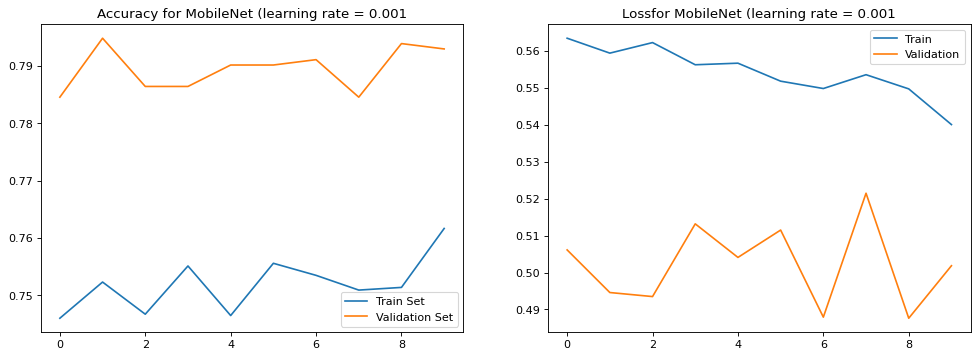

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 10
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(num_epochs),history1.history.get('accuracy'), label="Train Set")
plt.plot(np.arange(num_epochs),history1.history.get('val_accuracy'), label="Validation Set")
plt.title('Accuracy for MobileNet (learning rate = 0.001')
plt.legend()
plt.subplot(1, 2, 2) # row 1, col 2 index 2
plt.plot(np.arange(num_epochs),history1.history.get('loss'), label="Train")
plt.plot(np.arange(num_epochs),history1.history.get('val_loss'), label="Validation")
plt.title('Lossfor MobileNet (learning rate = 0.001')
plt.legend()
plt.show()



In [ ]:
# show the result 
y_pred = reloaded_model.predict(X_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

34/34 [==============================] - 1s 8ms/step
[[395 141]
 [ 81 455]]


In [ ]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.74      0.78       536
           1       0.76      0.85      0.80       536

    accuracy                           0.79      1072
   macro avg       0.80      0.79      0.79      1072
weighted avg       0.80      0.79      0.79      1072



In [ ]:
# evaluate the model
eval = reloaded_model.evaluate(X_test, y_test)
print(eval)

34/34 [==============================] - 0s 12ms/step - loss: 0.5018 - accuracy: 0.7929 - auc: 0.8718 - precision: 0.7634 - recall: 0.8489 - true_positives: 455.0000 - true_negatives: 395.0000 - false_positives: 141.0000 - false_negatives: 81.0000
[0.501839280128479, 0.7929104566574097, 0.8717959523200989, 0.7634228467941284, 0.8488805890083313, 455.0, 395.0, 141.0, 81.0]


## Fine-Tuning on Learning Rate

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

reloaded_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
history2 = reloaded_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
134/134 [==============================] - 11s 41ms/step - loss: 0.5249 - accuracy: 0.7698 - auc: 0.8490 - precision: 0.7862 - recall: 0.7411 - true_positives: 1589.0000 - true_negatives: 1712.0000 - false_positives: 432.0000 - false_negatives: 555.0000 - val_loss: 0.4981 - val_accuracy: 0.7938 - val_auc: 0.8745 - val_precision: 0.7553 - val_recall: 0.8694 - val_true_positives: 466.0000 - val_true_negatives: 385.0000 - val_false_positives: 151.0000 - val_false_negatives: 70.0000
Epoch 2/10
134/134 [==============================] - 3s 21ms/step - loss: 0.5217 - accuracy: 0.7789 - auc: 0.8513 - precision: 0.7859 - recall: 0.7668 - true_positives: 1644.0000 - true_negatives: 1696.0000 - false_positives: 448.0000 - false_negatives: 500.0000 - val_loss: 0.4960 - val_accuracy: 0.7966 - val_auc: 0.8747 - val_precision: 0.7556 - val_recall: 0.8769 - val_true_positives: 470.0000 - val_true_negatives: 384.0000 - val_false_positives: 152.0000 - val_false_negatives: 66.0000
Epoch 3/10


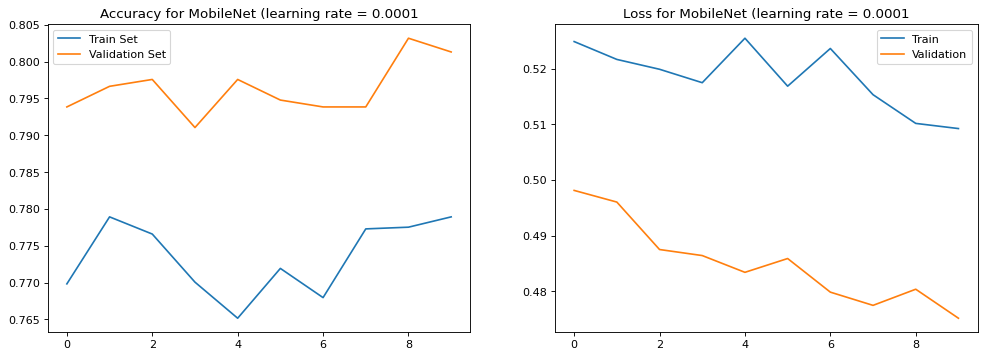

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 10
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(num_epochs),history2.history.get('accuracy'), label="Train Set")
plt.plot(np.arange(num_epochs),history2.history.get('val_accuracy'), label="Validation Set")
plt.title('Accuracy for MobileNet (learning rate = 0.0001')
plt.legend()
plt.subplot(1, 2, 2) # row 1, col 2 index 2
plt.plot(np.arange(num_epochs),history2.history.get('loss'), label="Train")
plt.plot(np.arange(num_epochs),history2.history.get('val_loss'), label="Validation")
plt.title('Loss for MobileNet (learning rate = 0.0001')
plt.legend()
plt.show()



In [ ]:
# show the result 
y_pred = reloaded_model.predict(X_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

#classification report
print(classification_report(y_test, y_pred))
# evaluate the model
eval = reloaded_model.evaluate(X_test, y_test)
print(eval)

34/34 [==============================] - 1s 8ms/step
[[401 135]
 [ 78 458]]
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       536
           1       0.77      0.85      0.81       536

    accuracy                           0.80      1072
   macro avg       0.80      0.80      0.80      1072
weighted avg       0.80      0.80      0.80      1072

34/34 [==============================] - 0s 12ms/step - loss: 0.4752 - accuracy: 0.8013 - auc: 0.8798 - precision: 0.7723 - recall: 0.8545 - true_positives: 458.0000 - true_negatives: 401.0000 - false_positives: 135.0000 - false_negatives: 78.0000
[0.47517797350883484, 0.8013059496879578, 0.8797650933265686, 0.7723439931869507, 0.85447758436203, 458.0, 401.0, 135.0, 78.0]


## Fine Tuning on Learning Rate and Dropout Rate

In [ ]:
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf

HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.05,0.1,0.2]))
HP_LR = hp.HParam('learning_rate', hp.Discrete([1e-4, 5e-4, 1e-3]))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_DROPOUT, HP_LR],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

def train_test_model(hparams):
    reloaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    reloaded_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    _, accuracy = reloaded_model.evaluate(X_test, y_test)
    return accuracy

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

session_num = 0

for dropout_rate in HP_DROPOUT.domain.values:
    for learning_rate in HP_LR.domain.values:
        hparams = {
            HP_DROPOUT: dropout_rate,
            HP_LR: learning_rate
        }
        run_name = "run-%d" % session_num
        print('--- [Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

--- [Starting trial: run-0
{'dropout': 0.05, 'learning_rate': 0.0001}
Epoch 1/10
134/134 [==============================] - 7s 23ms/step - loss: 0.5428 - accuracy: 0.7589 - val_loss: 0.4848 - val_accuracy: 0.8004
Epoch 2/10
134/134 [==============================] - 2s 14ms/step - loss: 0.5383 - accuracy: 0.7596 - val_loss: 0.4810 - val_accuracy: 0.8013
Epoch 3/10
134/134 [==============================] - 2s 16ms/step - loss: 0.5484 - accuracy: 0.7547 - val_loss: 0.4941 - val_accuracy: 0.7799
Epoch 4/10
134/134 [==============================] - 2s 16ms/step - loss: 0.5492 - accuracy: 0.7558 - val_loss: 0.5002 - val_accuracy: 0.7854
Epoch 5/10
134/134 [==============================] - 2s 14ms/step - loss: 0.5525 - accuracy: 0.7514 - val_loss: 0.4862 - val_accuracy: 0.7845
Epoch 6/10
134/134 [==============================] - 2s 14ms/step - loss: 0.5385 - accuracy: 0.7631 - val_loss: 0.5096 - val_accuracy: 0.7799
Epoch 7/10
134/134 [==============================] - 2s 14ms/step - los

## Final Model

{'dropout': 0.05, 'learning_rate': 0.0005} is the best performace in terms of its model accuracy

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

new_model = Sequential()
new_model.add(reloaded_model)
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.05))
new_model.add(Dense(1, activation='sigmoid'))

# Compile the model with a low learning rate and binary cross-entropy loss
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)
reloaded_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
history3 = reloaded_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
134/134 [==============================] - 7s 28ms/step - loss: 0.5227 - accuracy: 0.7787 - auc: 0.8530 - precision: 0.7799 - recall: 0.7766 - true_positives: 1665.0000 - true_negatives: 1674.0000 - false_positives: 470.0000 - false_negatives: 479.0000 - val_loss: 0.4856 - val_accuracy: 0.7948 - val_auc: 0.8770 - val_precision: 0.7715 - val_recall: 0.8377 - val_true_positives: 449.0000 - val_true_negatives: 403.0000 - val_false_positives: 133.0000 - val_false_negatives: 87.0000
Epoch 2/10
134/134 [==============================] - 2s 16ms/step - loss: 0.5215 - accuracy: 0.7845 - auc: 0.8521 - precision: 0.7793 - recall: 0.7938 - true_positives: 1702.0000 - true_negatives: 1662.0000 - false_positives: 482.0000 - false_negatives: 442.0000 - val_loss: 0.4886 - val_accuracy: 0.7957 - val_auc: 0.8767 - val_precision: 0.7664 - val_recall: 0.8507 - val_true_positives: 456.0000 - val_true_negatives: 397.0000 - val_false_positives: 139.0000 - val_false_negatives: 80.0000
Epoch 3/10
1

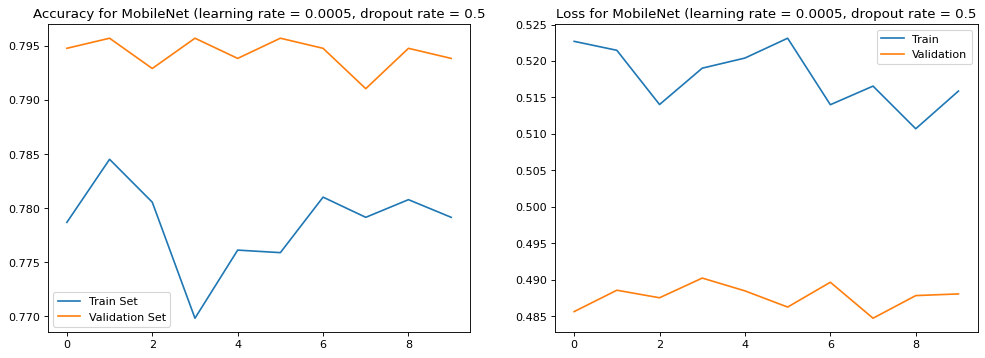

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 10
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(num_epochs),history3.history.get('accuracy'), label="Train Set")
plt.plot(np.arange(num_epochs),history3.history.get('val_accuracy'), label="Validation Set")
plt.title('Accuracy for MobileNet (learning rate = 0.0005, dropout rate = 0.5')
plt.legend()
plt.subplot(1, 2, 2) # row 1, col 2 index 2
plt.plot(np.arange(num_epochs),history3.history.get('loss'), label="Train")
plt.plot(np.arange(num_epochs),history3.history.get('val_loss'), label="Validation")
plt.title('Loss for MobileNet (learning rate = 0.0005, dropout rate = 0.5')
plt.legend()
plt.show()



In [ ]:
# show the result 
y_pred = reloaded_model.predict(X_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

#classification report
print(classification_report(y_test, y_pred))
# evaluate the model
eval = reloaded_model.evaluate(X_test, y_test)
print(eval)

34/34 [==============================] - 1s 13ms/step
[[392 144]
 [ 77 459]]
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       536
           1       0.76      0.86      0.81       536

    accuracy                           0.79      1072
   macro avg       0.80      0.79      0.79      1072
weighted avg       0.80      0.79      0.79      1072

34/34 [==============================] - 0s 12ms/step - loss: 0.4880 - accuracy: 0.7938 - auc: 0.8786 - precision: 0.7612 - recall: 0.8563 - true_positives: 459.0000 - true_negatives: 392.0000 - false_positives: 144.0000 - false_negatives: 77.0000
[0.4880492389202118, 0.7938432693481445, 0.8785642981529236, 0.7611940503120422, 0.8563432693481445, 459.0, 392.0, 144.0, 77.0]


In [ ]:
# create model using gpu
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add the data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Define the regularization strength
reg_strength = 0.001

# Create a new model using the base model and adding custom top layers
mobilemodel = tf.keras.models.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
mobilemodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Evaluate the model
loss, accuracy = mobilemodel.evaluate(X_test, y_test)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

120/120 [==============================] - 2s 17ms/step - loss: 0.5049 - accuracy: 0.7725
Test accuracy: 77.25%


## Hugging Face

In [ ]:
# SaveModel format for tensorflow serving
mobilemodel.save('mobilemodel')

In [ ]:
mobilemodel.build

<bound method Sequential.build of <keras.engine.sequential.Sequential object at 0x7f6a9050c3a0>>

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(mobilemodel, "mobilenet_v2_fake_image_detection_256")

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/554k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.80M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

'https://huggingface.co/Emmawang/mobilenet_v2_fake_image_detection_256/tree/main/'

## Mapping

Facial Expression

In [ ]:
import pandas as pd
df_csv = pd.read_csv('df_final (1).csv')

# delete rows after 21439
df_csv = df_csv.drop(df_csv.index[21439:])

In [ ]:
df_csv.FacialExp.unique()

array(['neg', 'neutral', 'pos'], dtype=object)

In [ ]:
import random

neg = []
for i in range(len(df_csv)):
    if df_csv['FacialExp'][i] == "neg":
        neg.append(i)

#randomly select 1000 images from neg
neg = random.sample(neg, 100)

# save the list of Unnamed: 0 that are pos Facial Expression
pos = []
for i in range(len(df_csv)):
    if df_csv['FacialExp'][i] == "pos":
        pos.append(i)
pos = random.sample(pos, 100)

# save the list of Unnamed: 0 that are neu Facial Expression
neu = []
for i in range(len(df_csv)):
    if df_csv['FacialExp'][i] == "neutral":
        neu.append(i)
neu = random.sample(neu, 100)

In [ ]:
correct = 0

for i in range(len(neg)):
    img = s3.Object(bucket_name, image_paths[neg[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of negative expression is {correct/ len(neg) * 100} %")

1/1 [==============================] - 0s 25ms/step
the accuracy of negative expression is 75.0 %


In [ ]:
correct = 0
for i in range(len(pos)):
    img = s3.Object(bucket_name, image_paths[pos[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of positive expression is {correct/ len(pos) * 100} %")

1/1 [==============================] - 0s 27ms/step
the accuracy of positive expression is 1.0 %
1/1 [==============================] - 0s 24ms/step
the accuracy of positive expression is 2.0 %
1/1 [==============================] - 0s 24ms/step
the accuracy of positive expression is 3.0 %
1/1 [==============================] - 0s 23ms/step
the accuracy of positive expression is 4.0 %
1/1 [==============================] - 0s 24ms/step
the accuracy of positive expression is 5.0 %
1/1 [==============================] - 0s 24ms/step
the accuracy of positive expression is 5.0 %
1/1 [==============================] - 0s 26ms/step
the accuracy of positive expression is 6.0 %
1/1 [==============================] - 0s 24ms/step
the accuracy of positive expression is 7.000000000000001 %
1/1 [==============================] - 0s 24ms/step
the accuracy of positive expression is 8.0 %
1/1 [==============================] - 0s 25ms/step
the accuracy of positive expression is 8.0 %
1/1 [===========

In [ ]:
correct = 0
for i in range(len(neu)):
    img = s3.Object(bucket_name, image_paths[neu[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of neutral expression is {correct/ len(neu) * 100} %")

1/1 [==============================] - 0s 24ms/step
the accuracy of neutral expression is 70.0 %


In [ ]:
man = []
for i in range(len(df_csv)):
    if df_csv['Gender'][i] == "Man":
        man.append(i)

#randomly select 1000 images from neg
man = random.sample(man, 100)

# save the list of Unnamed: 0 that are pos Facial Expression
woman = []
for i in range(len(df_csv)):
    if df_csv['Gender'][i] == "Woman":
        woman.append(i)
woman = random.sample(woman, 100)

In [ ]:
correct = 0
for i in range(len(man)):
    img = s3.Object(bucket_name, image_paths[man[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of male is {correct/ len(man) * 100} %")

1/1 [==============================] - 0s 25ms/step
the accuracy of male is 83.0 %


In [ ]:
correct = 0
for i in range(len(woman)):
    img = s3.Object(bucket_name, image_paths[woman[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of woman category is {correct/ len(woman) * 100} %")

1/1 [==============================] - 0s 24ms/step
the accuracy of woman category is 87.0 %


In [ ]:
glasses = []
for i in range(len(df_csv)):
    if df_csv['Glasses'][i] == "1":
        glasses.append(i)
glasses = random.sample(glasses, 100)

In [ ]:
noglasses = []
for i in range(len(df_csv)):
    if df_csv['Glasses'][i] == "0":
        noglasses.append(i)

noglasses = random.sample(noglasses, 100)


In [ ]:
correct = 0
for i in range(len(glasses)):
    img = s3.Object(bucket_name, image_paths[glasses[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of human faces with glasses is {correct/ len(glasses) * 100} %")

1/1 [==============================] - 0s 25ms/step
the accuracy of human faces with glasses is 74.0 %


In [ ]:
correct = 0
for i in range(len(noglasses)):
    img = s3.Object(bucket_name, image_paths[noglasses[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of human faces without glasses is {correct/ len(noglasses) * 100} %")

1/1 [==============================] - 0s 23ms/step
the accuracy of human faces without glasses is 78.0 %


In [ ]:
white = []
for i in range(len(df_csv)):
    if df_csv['Race'][i] == "white":
        white.append(i)

white = random.sample(white, 100)


In [ ]:
asian= []
for i in range(len(df_csv)):
    if df_csv['Race'][i] == "asian":
        asian.append(i)

asian = random.sample(asian, 100)


In [ ]:
black= []
for i in range(len(df_csv)):
    if df_csv['Race'][i] == "black":
        black.append(i)

black = random.sample(black, 100)


In [ ]:
correct = 0
for i in range(len(white)):
    img = s3.Object(bucket_name, image_paths[white[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of white category is {correct/ len(white) * 100} %")

1/1 [==============================] - 0s 24ms/step
the accuracy of white category is 80.0 %


In [ ]:
correct = 0
for i in range(len(asian)):
    img = s3.Object(bucket_name, image_paths[asian[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of asian category is {correct/ len(asian) * 100} %")

1/1 [==============================] - 0s 24ms/step
the accuracy of asian category is 76.0 %


In [ ]:
correct = 0
for i in range(len(black)):
    img = s3.Object(bucket_name, image_paths[black[i]])
    img = Image.open(img.get()['Body']).resize([128,128])
    img = np.array(img).astype(np.float32)
    img = img/255
    img = img.reshape(-1, 128, 128, 3)
    if mobilemodel.predict(img) < 0.5:
        correct += 1
print(f"the accuracy of black category is {correct/ len(black) * 100} %")

1/1 [==============================] - 0s 24ms/step
the accuracy of black category is 82.0 %


In [ ]:
from huggingface_hub import from_pretrained_keras

reloaded_model = from_pretrained_keras('Emmawang/mobilenet_v2_fake_image_detection')

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]